In [8]:
from wrappers import EnergyFunctionGenerator
import torch
from model import * 
from train_model import * 
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons

In [9]:
from model import * 
from train_model import * 


def pi(s):
    return torch.clamp(s, 0.0, 1.0)

class ExternalWorld:
    def __init__(self, x_values, y_values):
        self.x = torch.tensor(x_values, dtype=torch.float32)
        self.y = torch.tensor(y_values, dtype=torch.int64)
        self.size_dataset = len(self.x)



In [13]:
moon_x, moon_y = make_moons(n_samples=500, noise=0.1, random_state=42)
moon_world = ExternalWorld(moon_x, moon_y)

xor_x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]] * 10, dtype=np.float32)
xor_y = np.array([0, 1, 1, 0] * 10, dtype=np.int64)

print(type(moon_x))
print(type(xor_x))

xor_world = ExternalWorld(xor_x, xor_y)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [14]:


# small nets can solve xor
moon_net = Network(
    name="moon_net",
    external_world=xor_world,
    hyperparameters={
        "hidden_sizes": [4, 1],
        "output_size": 2,
        "batch_size": 4,
        "n_epochs": 1000,
        "n_it_neg": 10,
        "n_it_pos": 10,
        "alphas": [np.float32(0.1), np.float32(0.1),  np.float32(0.05)]
    }
)

# Train the network
train_net(moon_net, plot_graph= True)

Training Progress:   0%|          | 0/1000 [00:00<?, ?epoch/s]


TypeError: unsupported operand type(s) for *: 'numpy.float32' and 'Tensor'

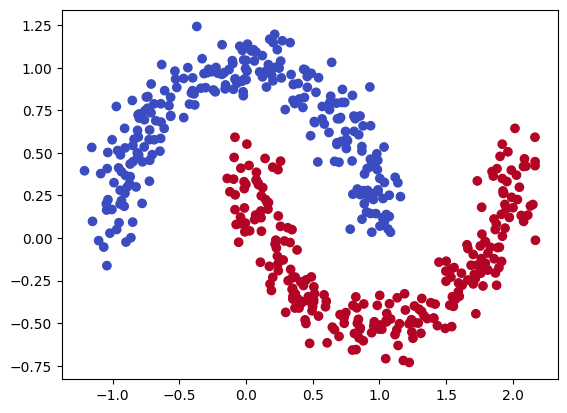

In [4]:

def pi(s):
    return torch.clamp(s, 0.0, 1.0)

class ExternalWorld:
    def __init__(self, x_values, y_values):
        self.x = torch.tensor(x_values, dtype=torch.float32)
        self.y = torch.tensor(y_values, dtype=torch.int64)
        self.size_dataset = len(self.x)


moon_x, moon_y = make_moons(n_samples=500, noise=0.1, random_state=42)
moon_world = ExternalWorld(moon_x, moon_y)

plt.scatter(moon_x[:,0], moon_x[:,1], c=moon_y, cmap='coolwarm')

In [6]:
moon_net = Network(
    name="moon_net",
    external_world=moon_world,
    hyperparameters={
        "hidden_sizes": [4, 1],
        "output_size": 2,
        "batch_size": 4,
        "n_epochs": 100,
        "n_it_neg": 10,
        "n_it_pos": 10,
        "alphas": [torch.float32(0.1), torch.float32(0.1),  torch.float32(0.05)]
    }
)

# Train the network
train_net(moon_net)

TypeError: 'torch.dtype' object is not callable

In [ ]:
wrap = EnergyFunctionGenerator(moon_net)
network_size = sum(wrap.get_network_sizes())

wrap.infer(moon_x[0,:])


energy_fn = wrap.build_unclamped_energy_fn()




In [ ]:
xor_x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]] * 10, dtype=np.float32)
xor_y = np.array([0, 1, 1, 0] * 10, dtype=np.int64)
xor_world = ExternalWorld(xor_x, xor_y)


#torch.tensor(xor_x, dtype=torch.float32).shape
torch.tensor(xor_y, dtype=torch.int64).shape

In [7]:
# XOR dataset
xor_x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]] * 10, dtype=np.float32)
xor_y = np.array([0, 1, 1, 0] * 10, dtype=np.int64)

# ExternalWorld instance with XOR data
xor_world = ExternalWorld(xor_x, xor_y)

# small nets can solve xor
xor_net = Network(
    name="xor_net",
    external_world=xor_world,
    hyperparameters={
        "hidden_sizes": [4, 1],
        "output_size": 2,
        "batch_size": 4,
        "n_epochs": 1000,
        "n_it_neg": 10,
        "n_it_pos": 10,
        "alphas": [np.float32(0.1), np.float32(0.1),  np.float32(0.05)]
    }
)

# Train the network
train_net(xor_net)

Training Progress:   0%|          | 0/1000 [00:00<?, ?epoch/s]


TypeError: unsupported operand type(s) for *: 'numpy.float32' and 'Tensor'

In [ ]:
wrap = EnergyFunctionGenerator(xor_net)
network_size = (1,sum(wrap.get_network_sizes()))
energy_fn = wrap.build_unclamped_energy_fn()

In [ ]:
s = torch.randn((1,9), requires_grad=True)
E = energy_fn(s)
print(E)
grads = torch.autograd.grad(E, s, retain_graph=True)

In [ ]:
import torch
import pyro
import pyro.infer.mcmc as mcmc

def hmc_sampler(energy_fn, init_state, num_samples=1000, step_size=0.1, num_steps=10, warmup_steps=200):
    """
    Runs Hamiltonian Monte Carlo (HMC) to sample from exp(-E(s))
    
    Args:
        energy_fn (callable): The energy function taking a tensor `s` and returning a scalar tensor.
        init_state (torch.Tensor): Initial state tensor of shape (batch_size, total_dim).
        num_samples (int): Number of samples to generate.
        step_size (float): Step size for HMC.
        num_steps (int): Number of leapfrog steps.
        warmup_steps (int): Number of warmup steps for adaptation.

    Returns:
        torch.Tensor: Samples of shape (num_samples, batch_size, total_dim).
    """

    def potential_fn(s):
        with pyro.plate("batch", s.shape[0], dim=-1):  # Batch-aware potential function
            return energy_fn(s).sum()

    # Define HMC kernel
    kernel = mcmc.HMC(potential_fn, step_size=step_size, num_steps=num_steps)

    # Run MCMC
    mcmc_run = mcmc.MCMC(kernel, num_samples=num_samples, warmup_steps=warmup_steps)
    mcmc_run.run(init_state)  # Initialize with the given state

    return mcmc_run.get_samples()  # Return collected samples


In [ ]:
init_state = torch.randn(1, 9, requires_grad=True)
samples = hmc_sampler(energy_fn, init_state, num_samples=1000)
print(samples)

In [ ]:
def energy_function(x):
    return 0.5 * torch.sum(x**2)

def potential_fn(x):
    return energy_function(x)  # HMC expects negative log-prob

In [ ]:


kernel = mcmc.HMC(energy_fn, step_size=0.1, num_steps=100)

mcmc_run = mcmc.MCMC(kernel, num_samples=1000, warmup_steps=200)
mcmc_run.run(torch.zeros(network_size))  # Initialize in 20D

# Get samples
samples = mcmc_run.get_samples()

print(samples)
